# PRÀCTICA 3: EXTRACCIÓ D'ENTITATS ANOMENADES

In [49]:
#lLIBRERIES
import nltk
from nltk.corpus import conll2002
from nltk.tag import CRFTagger
import timeit
import os
import pandas as pd
import re
import unicodedata
import io
from nltk.tokenize import sent_tokenize, word_tokenize

In [50]:
#CREAR DIRECTORI PELS MODELS
models_directory = 'models'
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

## DADES

In [51]:
#BAIXAR I GUARDAR DADES NECESSÀRIES
nltk.download('conll2002')
#ESPANYOL
train_IOB_ESP = conll2002.iob_sents('esp.train') #train
val_IOB_ESP = conll2002.iob_sents('esp.testa') #validation
test_IOB_ESP = conll2002.iob_sents('esp.testb') #test

#NEERLANDÈS
train_IOB_NED = conll2002.iob_sents('ned.train') #train
val_IOB_NED  = conll2002.iob_sents('ned.testa') #validation
test_IOB_NED = conll2002.iob_sents('ned.testb') #test

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\llumf\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!


## FUNCIONS PER ELS MODELS

### VALIDACIÓ

In [52]:
# AGAFA LES DADES IMPORTANTS/ÚTILS (les "o" les elimina)
def filtrar_tags(lista_de_listas):
    resultado = []

    for frase in lista_de_listas:
        nueva_frase = []
        i = 0
        while i < len(frase):
            tag = frase[i][0:2]
            camp = frase[i][2:]
            if tag == "B-" or tag == 'U-' or tag == 'S-':
                inici = i
                while i + 1 < len(frase) and (frase[i + 1][0:2] == "I-" or frase[i + 1][0:2] == "E-"):
                    i += 1
                nueva_frase.append((inici,i,camp))
            elif tag == "I-":
                inici = i
                while i + 1 < len(frase) and (frase[i + 1][0:2] == "I-"):
                    i += 1
                nueva_frase.append((inici,i,camp))
            i += 1
        resultado.append(nueva_frase)
    return resultado

In [53]:
# CÀLCUL DE VALORS "Correct matches", "Partial matches", "Incorrect matches", "Missing matches" i "Spurious matches"
def tutu(real,pred):
    c, p, i, m, s = 0, 0, 0, 0, 0
    parcials = (-1,-1,'',False)
    for sent, sentence in enumerate(pred): # [1 (0, 1, 'LOC'), 2 (3,7,'pers')]
        for ini_p,fi_p,tag_p in sentence: # [0, 1, 'LOC'] pred
            for ini_r,fi_r,tag_r in real[sent]: #[0, 1, 'LOC'] real
                #es parcial de l'anterior?
                if ini_p<=parcials[1] and tag_p==parcials[2]:
                    if not parcials[3]:
                        p += 0.5
                    parcials = (ini_r,fi_r,tag_r,True)
                    real[sent].remove((ini_r,fi_r,tag_r))
                    break
                #es correcta?
                elif ini_r==ini_p and fi_r==fi_p:
                    if tag_r == tag_p:
                        c+= 1
                    else:
                        i+=1
                    real[sent].remove((ini_r,fi_r,tag_r))
                    break
                #es parcial: considerem només eparcials que siguin més petites
                elif ini_r<=ini_p and fi_r>=fi_p:
                    if tag_r == tag_p:
                        p +=1
                        parcials = (ini_r,fi_r,tag_r,False)
                    else:
                        i+=1
                    real[sent].remove((ini_r,fi_r,tag_r))
                    break
                # trobat que no ho es
                elif ini_r > fi_p:
                    s+=1
                    break
            if real[sent] == []:
                if ini_p<=parcials[1] and tag_p==parcials[2]:
                    if not parcials[3]:
                        p += 0.5
                    parcials = (ini_r,fi_r,tag_r,True)
        m += len(real[sent])

    return c, p, i, m, s

In [54]:
#CALCULA DIFERENTS ACCURACY (Rec, Prec i F1)
def accuracies(tupl):
    c, p, i, m, s = tupl
    recall = (c+1/2*p)/(c+i+p+m)
    precision = (c+1/2*p)/(c+i+p+s)
    f1 = 2 * (precision*recall)/(precision+recall)
    return recall, precision, f1

### CODIFICACIÓ

In [55]:
#PASA LES DADES DEL ENCODING BIO A IO
def bio_to_io(sent):
    io_sent = []
    for word, pos, bio in sent:
        if bio.startswith('B') or bio.startswith('I'):
            tag = 'I'
        else:
            tag = 'O'
        io_sent.append((word, pos, f'{tag}-{bio[2:]}'))
    return io_sent

In [56]:
#PASA LES DADES DEL ENCODING BIO A BIOU
def bio_to_biou(sent):
    biow_sent = []
    for i, (word, pos, iob) in enumerate(sent):
        if iob.startswith('B'):
            tag = 'B'
        elif iob.startswith('I'):
            if i + 1 < len(sent) and sent[i + 1][2].startswith('I'):
                tag = 'I'
            else:
                tag = 'E'
        else:
            tag = 'O'
        biow_sent.append((word, pos, f'{tag}-{iob[2:]}'))
    return biow_sent

In [57]:
#PASA LES DADES DEL ENCODING BIO A BIOEU
def bio_to_bioeu(sent):
    bioeu_sent = []
    for i, (word, pos, bio) in enumerate(sent):
        if bio.startswith('B'):
            if i + 1 < len(sent) and sent[i + 1][2].startswith('I'):
                tag = 'B'
            else:
                tag = 'U'
        elif bio.startswith('I'):
            if i + 1 < len(sent) and sent[i + 1][2].startswith('I'):
                tag = 'I'
            else:
                tag = 'E'
        else:
            tag = 'O'
        bioeu_sent.append((word, pos, f'{tag}-{bio[2:]}'))
    return bioeu_sent

In [58]:
#PASA LES DADES DEL ENCODING BIO A BIOEU+
def bio_to_bioeu_plus(sent):
    bioeu_plus_sent = []
    for i, (word, pos, bio) in enumerate(sent):
        if bio.startswith('B'):
            if i + 1 < len(sent) and sent[i + 1][2].startswith('I'):
                tag = 'B'
            else:
                tag = 'U'
        elif bio.startswith('I'):
            if i + 1 < len(sent) and sent[i + 1][2].startswith('I'):
                tag = 'I'
            else:
                tag = 'E'
        elif bio.startswith('O'):
            if (i == 0 or sent[i - 1][2] == 'O') and (i + 1 == len(sent) or sent[i + 1][2] == 'O'):
                tag = 'S'
            else:
                tag = 'O'
        bioeu_plus_sent.append((word, pos, f'{tag}-{bio[2:]}'))
    return bioeu_plus_sent

### FEATURES

In [59]:
# CREA FEATURES NOUS
class FeatureDetector:
    def __init__(self, cap=0, num=0, punt=0, suf=0, lon=0, pref=0, lemma=0, postag=0, ant=0, post=0, gazatteers=None, list_words=None):
        self._pattern = re.compile(r'\d')
        self.cap = cap
        self.num = num
        self.punt = punt
        self.suf = suf
        self.lon = lon
        self.pref = pref
        self.lemma = lemma
        self.postag = postag
        self.ant = ant
        self.post = post
        self.gazatteers = gazatteers if gazatteers else []
        self.list_words = list_words if list_words else []

    def __call__(self, tokens, index):
        token = tokens[index][0]
        feature_list = []


        # Capitalization
        if self.cap==1:
            if token[0].isupper():
                feature_list.append("CAPITALIZATION")

        # Number
        if self.num==1:
            if re.search(self._pattern, token) is not None:
                feature_list.append("HAS_NUM")

        # Punctuation
        if self.punt==1:
            punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
            if all(unicodedata.category(x) in punc_cat for x in token):
                feature_list.append("PUNCTUATION")

        # Suffix up to length 3
        if self.suf==1:
            if len(token) > 1:
                feature_list.append("SUF_" + token[-1:])
            if len(token) > 2:
                feature_list.append("SUF_" + token[-2:])
            if len(token) > 3:
                feature_list.append("SUF_" + token[-3:])

        # Length of word
        if self.lon==1:
            feature_list.append(f"LENGTH_{len(token)}")

        # Prefix up to length 3
        if self.pref:
            if len(token) > 1:
                feature_list.append("PREF_" + token[:1])
            if len(token) > 2:
                feature_list.append("PREF_" + token[:2])
            if len(token) > 3:
                feature_list.append("PREF_" + token[:3])

        # Lemma (assuming English for simplicity)
        if self.lemma==1:
            from nltk.stem import WordNetLemmatizer
            lemmatizer = WordNetLemmatizer()
            feature_list.append(f"LEMMA_{lemmatizer.lemmatize(token)}")

        # POS Tag
        if self.postag==1:
            pos_tag = tokens[index][1]
            feature_list.append(f"POSTAG_{pos_tag}")

        # Paraula anterior
        if self.ant == 1:
            if index > 0:
                anterior = tokens[index-1][0]
            else:
                anterior = '.'
            feature_list.append(f"ANT_{anterior}")

        #Paraula posterior
        if self.post == 1:
            if index < len(tokens):
                posterior = tokens[index][0]
            else:
                posterior = '.'
            feature_list.append(f"POST_{posterior}")

        # Gazatteers: localizations
        if self.gazatteers:
            if token in self.gazatteers:
                feature_list.append("IN_GAZATTEERS")

        # List of words: other name entities different to localization
        if self.list_words:
            if token in self.list_words:
                feature_list.append("IN_LIST_WORDS")

        feature_list.append("WORD_" + token)
        return dict(zip(feature_list, [True]*len(feature_list)))
    
    def features(self):
        if self.gazatteers:
            a = 1
        else:
            a = 0
        if self.list_words:
            b = 1
        else:
            b = 0
        return((self.cap, self.num, self.punt, self.suf, self.lon, self.pref, self.lemma, self.postag,self.ant,self.post,a,b))

#### DESCARREGAR SETS AMB GEZTTEERS DE LOCALITZACIÓ I GENÈRICS

In [60]:
def obrit_doc(directorio, idioma):
    sett = set()
    
    def cargar_set(directorio):
        nonlocal sett  # Declaramos sett como nonlocal
        # Recorre todos los archivos en el directorio
        for nombre_archivo in os.listdir(directorio):
            # Solo considera archivos .txt
            if nombre_archivo.endswith('.txt'):
                # Abre el archivo y lee las palabras
                with io.open(os.path.join(directorio, nombre_archivo), 'r', encoding='utf8') as f:
                    palabras = f.read().split()
                    sett.update(palabras)

            # Solo considera archivos .xlsx
            elif nombre_archivo.endswith('.xlsx'):
                # Lee el archivo de Excel
                df = pd.read_excel(os.path.join(directorio, nombre_archivo))
                # Asume que las palabras están en la primera columna
                palabras = []
                for celda in df.iloc[:, 0].tolist():
                    palabras.extend(str(celda).split())  # Convierte el contenido de la celda a string y lo divide en palabras
                sett.update(palabras)

    directorio1 = os.path.join("gazetteers", directorio)

    cargar_set(directorio1)  # Ahora se llama después de definir la función

    directorio2 = os.path.join(directorio1, idioma)
    cargar_set(directorio2)  # Ahora se llama después de definir la función
    
    return sett


In [61]:
#SET AMB GEZTTEERS GENÈRICS (extrets de la carpeta OTROS)
##ESPANYOL
otros_ESP = obrit_doc('OTROS','ESP')
##NEERLANDÈS
otros_NED = obrit_doc('OTROS','NL')

#SET AMB GEZTTEERS DE LOCALITZACIÓ (extrets de la carpeta LOC)
##ESPANYOL
loc_ESP = obrit_doc('LOC','ESP')
##NEERLANDÈS
loc_NED = obrit_doc('LOC','NL')

### MODEL

In [62]:
#FUNCIÓ PER TOKENITZAR ELS TEXTOS EXTERNS
def tokenize_and_tag(text):
    # Tokenizar el texto
    tokens = nltk.word_tokenize(text)

    # Etiquetar las palabras
    tagged_tokens = nltk.pos_tag(tokens)

    return tagged_tokens

In [91]:
# EXPERIMENTACIÓ AMB FEATURES
class model:
    def __init__(self,language, encoding, feature_function = FeatureDetector()):
        self.language = language
        self.encoding = encoding
        self.feature_function = feature_function
        self.model_output_path = ''
        self.train_data = None
        self.val_data = None
        self.val_out = None
        self.test_data = None
        self.test_out = None
        self.path()

    def path(self):
        tupl = self.feature_function.features()
        seq = ''.join(map(str, tupl))
        self.model_output_path = f'models/{self.encoding}_{self.language}_{seq}.mdl'

    def data_train(self):
        train = eval(f'train_IOB_{self.language}')
        if not self.encoding == 'IOB':
            fn = eval(f'bio_to_{self.encoding.lower()}')
            tra = [fn(sent) for sent in train]
            training = [[((token,postag), tag) for token, postag, tag in sent] for sent in tra]
        else:
            training = [[((token,postag), tag) for token, postag, tag in sent] for sent in train]
        self.train_data = training

    def data_val(self):
        val = eval(f'val_IOB_{self.language}')
        data, out = [[(token,postag) for token, postag, _ in sent] for sent in val], [[tag for _, _, tag in sent] for sent in val]
        self.val_out = out
        if not self.encoding == 'IOB':
            fn = eval(f'bio_to_{self.encoding.lower()}')
            vali = [fn(sent) for sent in val]
            validation = [[(token,postag) for token, postag, _ in sent] for sent in vali]
        else:
            validation = data
        self.val_data = validation

    def data_test(self):
        test = eval(f'test_IOB_{self.language}')
        data, out = [[(token,postag) for token, postag, _ in sent] for sent in test], [[tag for _, _, tag in sent] for sent in test]
        self.test_out = out
        if not self.encoding == 'IOB':
            fn = eval(f'bio_to_{self.encoding.lower()}')
            testt = [fn(sent) for sent in test]
            testing = [[(token,postag) for token, postag, _ in sent] for sent in testt]
        else:
            testing = data
        self.test_data = testing
    
    def train_model(self):
        self.data_train()
        if not os.path.exists(self.model_output_path):
            crf_model = nltk.tag.CRFTagger(feature_func=self.feature_function)
            crf_model.train(self.train_data, self.model_output_path)
        else:
            print(f'  El model {self.model_output_path[7:]} ja estava entrenat')

    def validate_model(self):
        self.data_val()
        start_time = timeit.default_timer()
        crf_model = nltk.tag.CRFTagger(feature_func = self.feature_function) #no oblidar de passar la feature function
        crf_model.set_model_file(self.model_output_path)
        predict = crf_model.tag_sents(self.val_data)
        pred = [[tag for _, tag in sent] for sent in predict]
        tupla = tutu(filtrar_tags(self.val_out),filtrar_tags(pred))
        recall, precission, f1_score = accuracies(tupla)
        elapsed_time = timeit.default_timer() - start_time
        return recall, precission, f1_score, elapsed_time

    def test_model(self):
        self.data_test()
        crf_model = nltk.tag.CRFTagger(feature_func = self.feature_function) #no oblidar de passar la feature function
        crf_model.set_model_file(self.model_output_path)
        predict = crf_model.tag_sents(self.test_data)
        pred = [[tag for _, tag in sent] for sent in predict]
        tupla = tutu(filtrar_tags(self.test_out),filtrar_tags(pred))
        recall, precission, f1_score = accuracies(tupla)
        return recall, precission, f1_score
    
    def try_text(self,text):
        dades = [tokenize_and_tag(t) for t in sent_tokenize(text)]
        crf_model = nltk.tag.CRFTagger(feature_func = self.feature_function) #no oblidar de passar la feature function
        crf_model.set_model_file(self.model_output_path)
        predict = crf_model.tag_sents(dades)
        pred = [[tag for _, tag in sent] for sent in predict]
        return dades, filtrar_tags(pred)


## EXPERIMENTACIÓ

### FEATURES

In [64]:
#FUNCIÓ BACKWARD ELIMINATION
def backward_elimination(lan):
    if lan == 'ESP':
        loc = loc_ESP
        otros = otros_ESP
    else:
        loc = loc_NED
        otros = otros_NED
    results = []
    maxim = 0
    def Rbackward_elimination(tupl):
        nonlocal maxim
        g = []
        h = []
        for i in range(len(tupl)):
            a = list(tupl)
            a[i] = 0
            tupla = tuple(a)
            cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc1,otros1 = tupla
            mod = model(lan,'IOB',FeatureDetector(cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc1,otros1))
            mod.train_model()
            recall,precission,f1_score,elapsed_time = mod.validate_model()
            loc_bin = 0 if loc1==0 else 1
            otros_bin = 0 if otros1==0 else 1
            tpl = (cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc_bin,otros_bin)
            results.append([mod.model_output_path,tpl,recall,precission,f1_score,elapsed_time])
            h.append(tupla)
            g.append(f1_score)
        if max(g) > maxim and tupla != tupl:
            maxim = max(g)
            max_mod = h[g.index(maxim)]
            return Rbackward_elimination(max_mod)
        else:
            cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc1,otros1 = tupl
            loc_bin = 0 if loc1==0 else 1
            otros_bin = 0 if otros1==0 else 1
            tupla_millor = (cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc_bin,otros_bin)
            return maxim, tupla_millor
        
    maxim_f1score, millor_model = Rbackward_elimination((1,1,1,1,1,1,1,1,1,1,loc,otros))
    return maxim_f1score,millor_model,results


#### ESPANYOL

In [ ]:
maxim_f1_score_esp, millor_model_esp, resultats_esp = backward_elimination('ESP')

In [33]:
models_feat_esp = pd.DataFrame(resultats_esp)
models_feat_esp.columns = ['path','tupla','recall','precission','f1 score', 'tiempo de validación']
models_feat_esp.to_csv('model_features_esp.csv')

#### NEERLANDÉS

In [24]:
maxim_f1_score_ned, millor_model_ned, resultats_ned = backward_elimination('NED')

El model IOB_NED_110111111111.mdl ja estava entrenat


In [34]:
models_feat_ned = pd.DataFrame(resultats_ned)
models_feat_ned.columns = ['path','tupla','recall','precission','f1 score', 'tiempo de validación']
models_feat_ned.to_csv('model_features_ned.csv')

### CODIFICACIONS

In [18]:
def comparar_codificacions(lan):
    millor_model = eval(f'millor_model_{lan.lower()}')
    cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc,otros = millor_model
    results = []
    if loc == 1:
        loc = eval(f'loc_{lan}')
    if otros == 1:
        otros = eval(f'otros_{lan}')
    for encod in ['IOB','IO','BIOU','BIOEU','BIOEU_PLUS']:
        mod = model('ESP',encod,FeatureDetector(cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc,otros))
        mod.train_model()
        recall,precission,f1_score,elapsed_time = mod.validate_model()
        results.append([encod, recall,precission,f1_score,elapsed_time])
    return results

#### Espanyol

In [38]:
# PER SI NO ES VOL EXECUTAR TOT EL BACKWARD ELIMINATION:
millor_model_esp = (1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1)
millor_model_ned = (1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)

In [35]:
db_esp = comparar_codificacions('ESP')
results_esp = pd.DataFrame(db_esp)
results_esp.columns = ['encoding', 'recall','precission','f1 score', 'tiempo de validación']
results_esp

  El model IOB_ESP_111110111111.mdl ja estava entrenat
  El model IO_ESP_111110111111.mdl ja estava entrenat
  El model BIOU_ESP_111110111111.mdl ja estava entrenat
  El model BIOEU_ESP_111110111111.mdl ja estava entrenat
  El model BIOEU_PLUS_ESP_111110111111.mdl ja estava entrenat


,encoding,recall,precission,f1 score,tiempo de validación
0,IOB,0.725347,0.773284,0.748549,0.861244
1,IO,0.699425,0.757061,0.727103,0.818845
2,BIOU,0.731082,0.772452,0.751198,0.834681
3,BIOEU,0.735681,0.771860,0.753337,0.935326
4,BIOEU_PLUS,0.721432,0.126453,0.215187,0.970124


In [81]:
millor_cod_esp = results_esp[results_esp['f1 score']==max(results_esp['f1 score'])]['encoding']
millor_cod_esp = millor_cod_esp.to_numpy()[0]
print('La millor codificació per a Espanyol és:',millor_cod_esp)

La millor codificació per a Espanyol és: BIOEU


#### Neerlandès

In [39]:
db_ned = comparar_codificacions('NED')
results_ned = pd.DataFrame(db_ned)
results_ned.columns = ['encoding', 'recall','precission','f1 score', 'tiempo de validación']
results_ned

  El model IOB_ESP_110111111111.mdl ja estava entrenat
  El model IO_ESP_110111111111.mdl ja estava entrenat
  El model BIOU_ESP_110111111111.mdl ja estava entrenat
  El model BIOEU_ESP_110111111111.mdl ja estava entrenat
  El model BIOEU_PLUS_ESP_110111111111.mdl ja estava entrenat


,encoding,recall,precission,f1 score,tiempo de validación
0,IOB,0.721308,0.767649,0.743757,0.795422
1,IO,0.701873,0.760112,0.729833,1.221701
2,BIOU,0.733716,0.768883,0.750888,0.833488
3,BIOEU,0.742120,0.775062,0.758234,0.847316
4,BIOEU_PLUS,0.724379,0.126922,0.215999,0.880945


In [82]:
millor_cod_ned = results_ned[results_ned['f1 score']==max(results_ned['f1 score'])]['encoding']
millor_cod_ned = millor_cod_ned.to_numpy()[0]
print('La millor codificació per a Neerlandès és:',millor_cod_ned)

La millor codificació per a Neerlandès és: BIOEU


### ANÀLISI DELS MODELS

#### Comparació de features

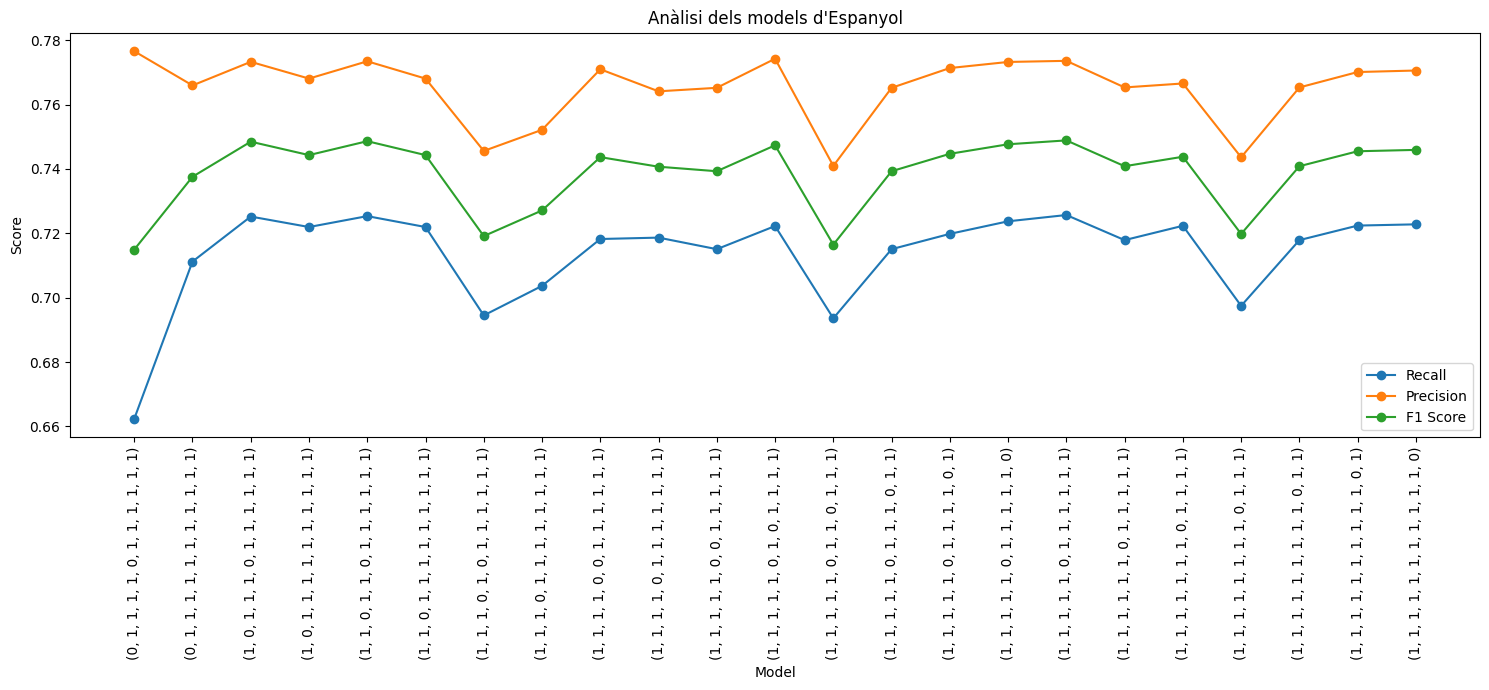

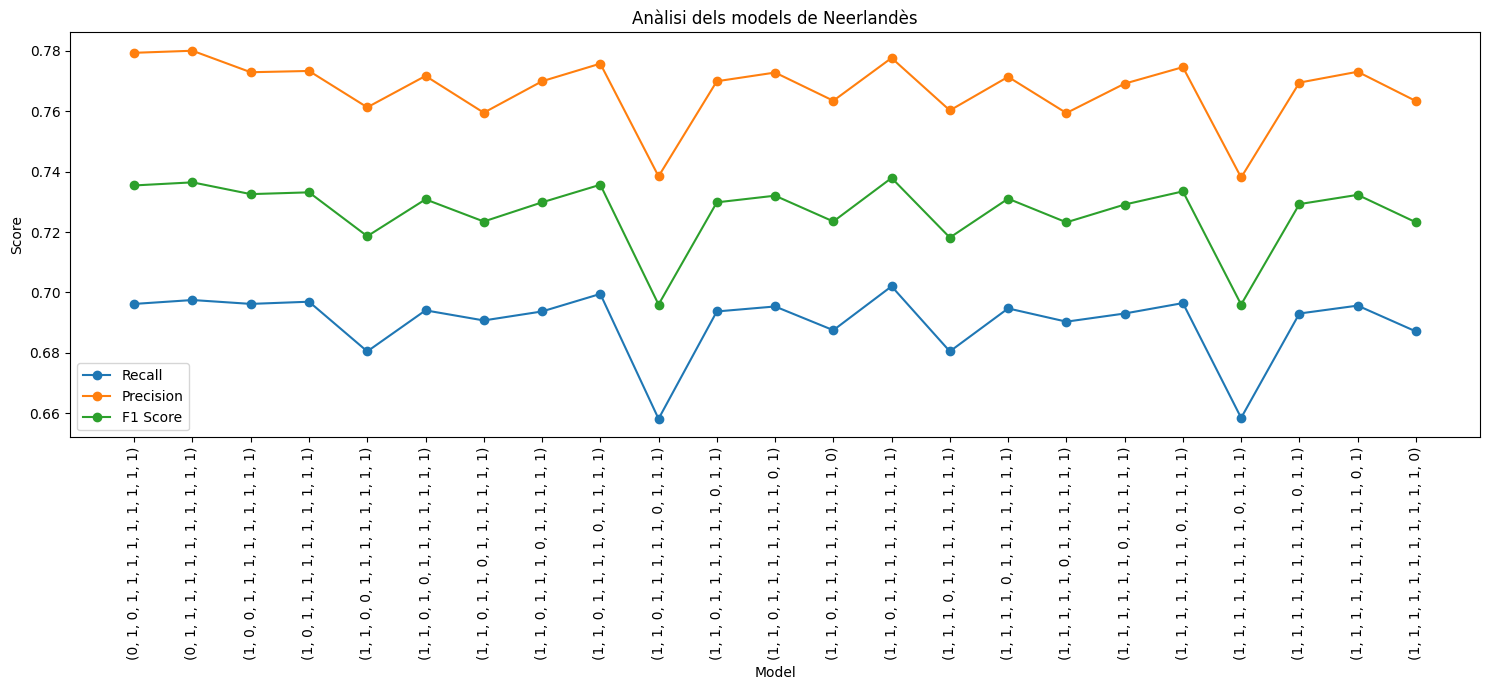

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos en español
df_esp = pd.read_csv('model_features_esp.csv')

# Eliminar duplicados
df_esp = df_esp.drop_duplicates(subset='tupla', keep="first")

# Ordenar los datos por el modelo para que el gráfico sea más fácil de leer
df_esp = df_esp.sort_values(by='tupla')

# Crear un nuevo gráfico para el idioma español
plt.figure(figsize=(15,7))

# Añadir los datos al gráfico para el idioma español
plt.plot(df_esp['tupla'], df_esp['recall'], marker='o', label='Recall')
plt.plot(df_esp['tupla'], df_esp['precission'], marker='o', label='Precision')
plt.plot(df_esp['tupla'], df_esp['f1 score'], marker='o', label='F1 Score')

# Añadir títulos y etiquetas para el idioma español
plt.title("Anàlisi dels models d'Espanyol")
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()

# Rotar las etiquetas del eje x para que sean más fáciles de leer
plt.xticks(rotation=90)

# Mostrar el gráfico para el idioma español
plt.tight_layout()
plt.show()


# Cargar datos en neerlandés
df_ned = pd.read_csv('model_features_ned.csv')

# Eliminar duplicados
df_ned = df_ned.drop_duplicates(subset='tupla', keep="first")

# Ordenar los datos por el modelo para que el gráfico sea más fácil de leer
df_ned = df_ned.sort_values(by='tupla')

# Crear un nuevo gráfico para el idioma neerlandés
plt.figure(figsize=(15,7))

# Añadir los datos al gráfico para el idioma neerlandés
plt.plot(df_ned['tupla'], df_ned['recall'], marker='o', label='Recall')
plt.plot(df_ned['tupla'], df_ned['precission'], marker='o', label='Precision')
plt.plot(df_ned['tupla'], df_ned['f1 score'], marker='o', label='F1 Score')

# Añadir títulos y etiquetas para el idioma neerlandés
plt.title('Anàlisi dels models de Neerlandès')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()

# Rotar las etiquetas del eje x para que sean más fáciles de leer
plt.xticks(rotation=90)

# Mostrar el gráfico para el idioma neerlandés
plt.tight_layout()
plt.show()


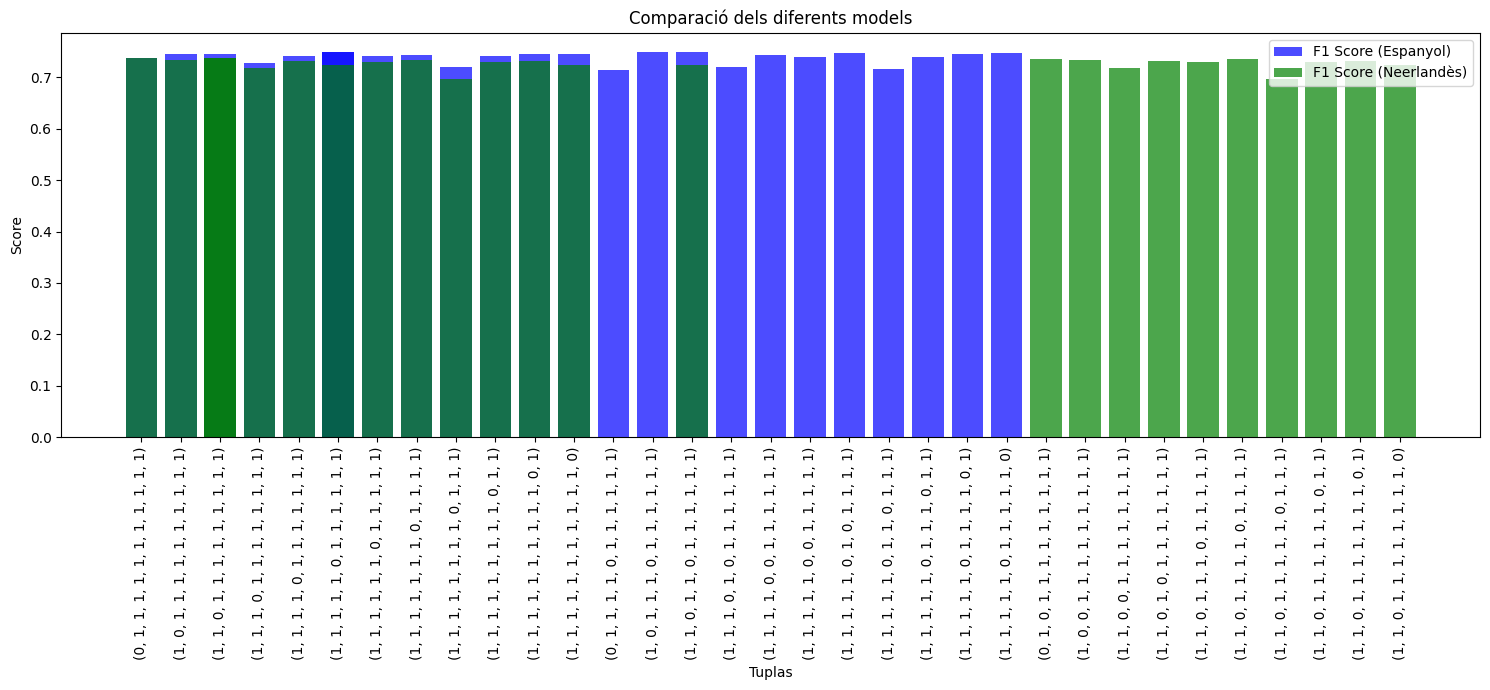

In [45]:
def plot_two_languages():
    # Datos en español
    data_esp = pd.read_csv('model_features_esp.csv')

    # Datos en neerlandés
    data_ned = pd.read_csv('model_features_ned.csv')

    # Crea un nuevo gráfico
    plt.figure(figsize=(15,7))

    # Añade los datos en español al gráfico
    plt.bar(data_esp['tupla'], data_esp['f1 score'], color='b', alpha=0.7, label='F1 Score (Espanyol)')

    # Añade los datos en neerlandés al gráfico
    plt.bar(data_ned['tupla'], data_ned['f1 score'], color='g', alpha=0.7, label='F1 Score (Neerlandès)')

    # Añade títulos y etiquetas
    plt.xlabel('Tuplas')
    plt.ylabel('Score')
    plt.title('Comparació dels diferents models')
    plt.xticks(rotation=90) # Esto hace que las etiquetas del eje x se giren 90 grados para evitar la superposición.
    plt.legend()

    # Muestra el gráfico
    plt.tight_layout()
    plt.show()

# Llama a la función para generar el gráfico
plot_two_languages()


#### Comparació de codificacions

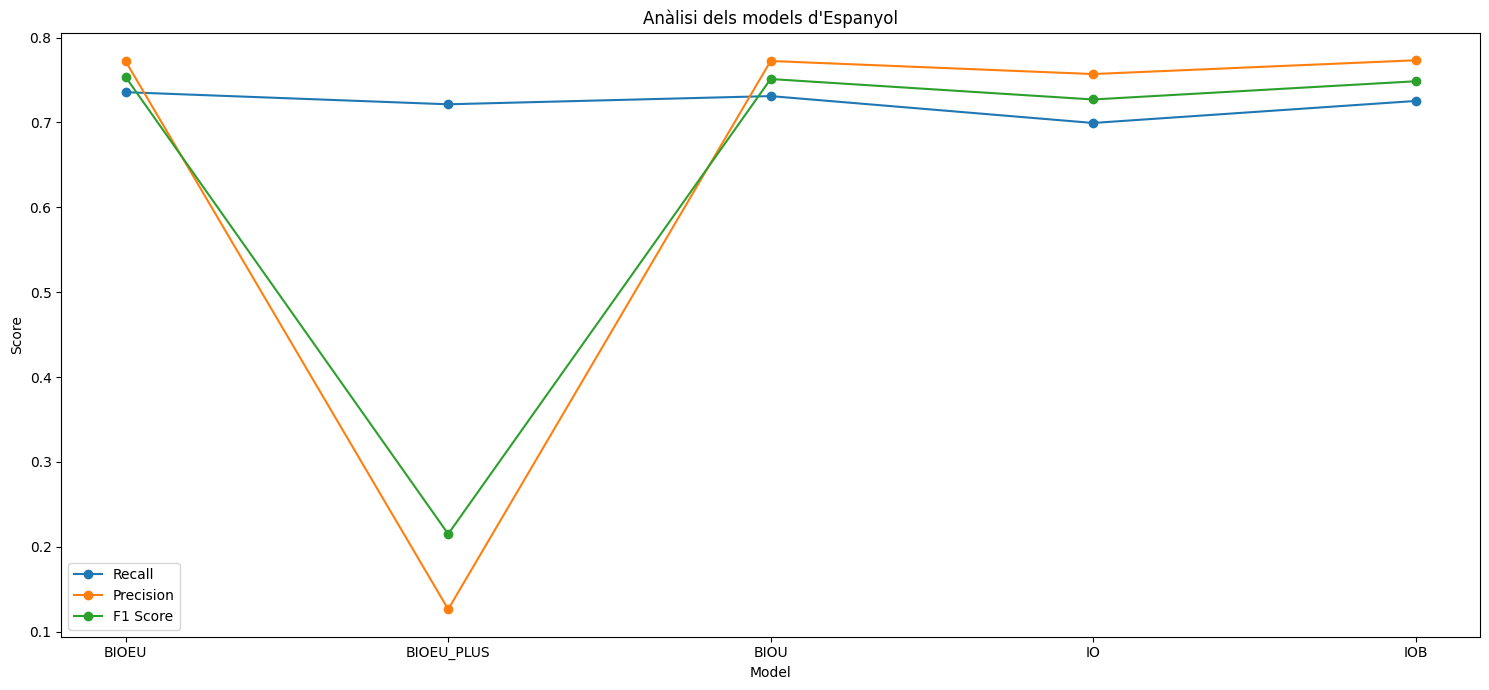

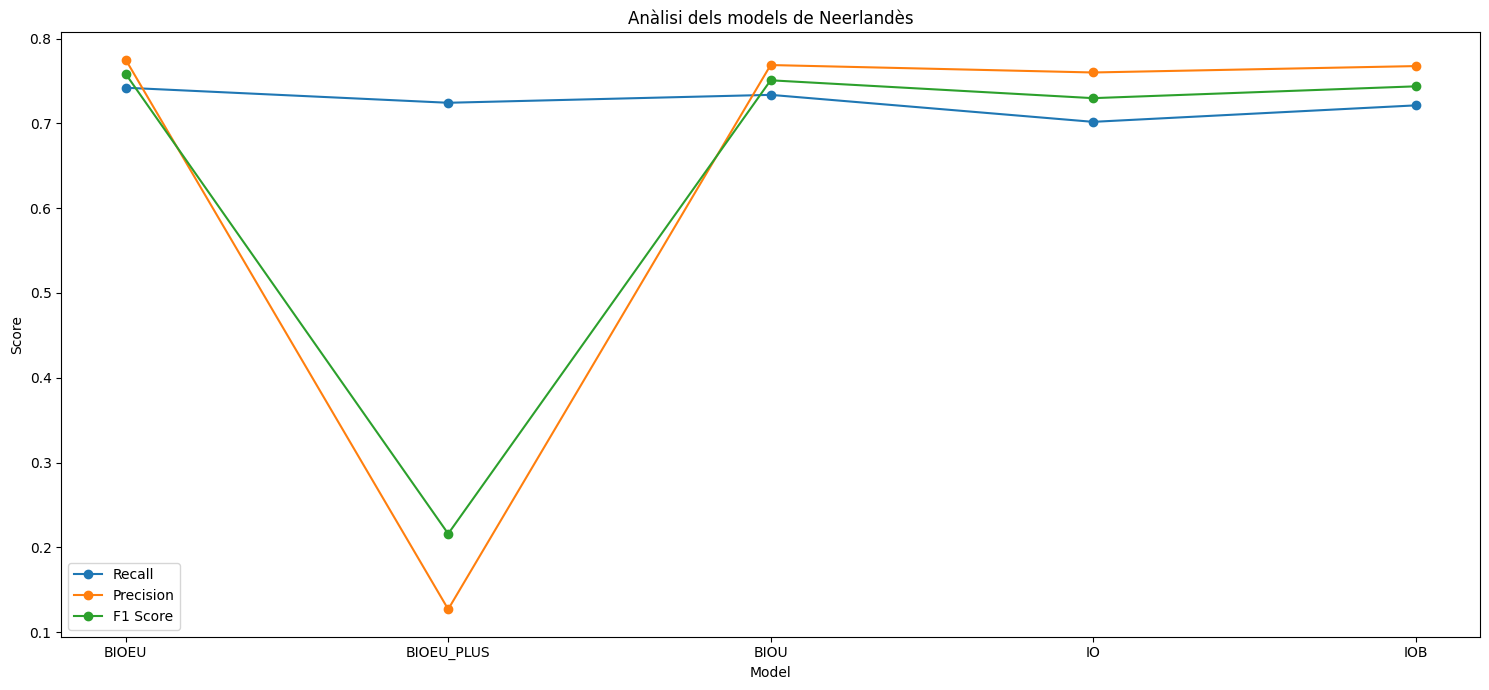

In [66]:

# Cargar datos en español
df_esp = results_esp

# Eliminar duplicados
df_esp = df_esp.drop_duplicates(subset='encoding', keep="first")

# Ordenar los datos por el modelo para que el gráfico sea más fácil de leer
df_esp = df_esp.sort_values(by='encoding')

# Crear un nuevo gráfico para el idioma español
plt.figure(figsize=(15,7))

# Añadir los datos al gráfico para el idioma español
plt.plot(df_esp['encoding'], df_esp['recall'], marker='o', label='Recall')
plt.plot(df_esp['encoding'], df_esp['precission'], marker='o', label='Precision')
plt.plot(df_esp['encoding'], df_esp['f1 score'], marker='o', label='F1 Score')

# Añadir títulos y etiquetas para el idioma español
plt.title("Anàlisi dels models d'Espanyol")
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()


# Mostrar el gráfico para el idioma español
plt.tight_layout()
plt.show()


# Cargar datos en neerlandés
df_ned = results_ned

# Eliminar duplicados
df_ned = df_ned.drop_duplicates(subset='encoding', keep="first")

# Ordenar los datos por el modelo para que el gráfico sea más fácil de leer
df_ned = df_ned.sort_values(by='encoding')

# Crear un nuevo gráfico para el idioma neerlandés
plt.figure(figsize=(15,7))

# Añadir los datos al gráfico para el idioma neerlandés
plt.plot(df_ned['encoding'], df_ned['recall'], marker='o', label='Recall')
plt.plot(df_ned['encoding'], df_ned['precission'], marker='o', label='Precision')
plt.plot(df_ned['encoding'], df_ned['f1 score'], marker='o', label='F1 Score')

# Añadir títulos y etiquetas para el idioma neerlandés
plt.title('Anàlisi dels models de Neerlandès')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()

# Mostrar el gráfico para el idioma neerlandés
plt.tight_layout()
plt.show()


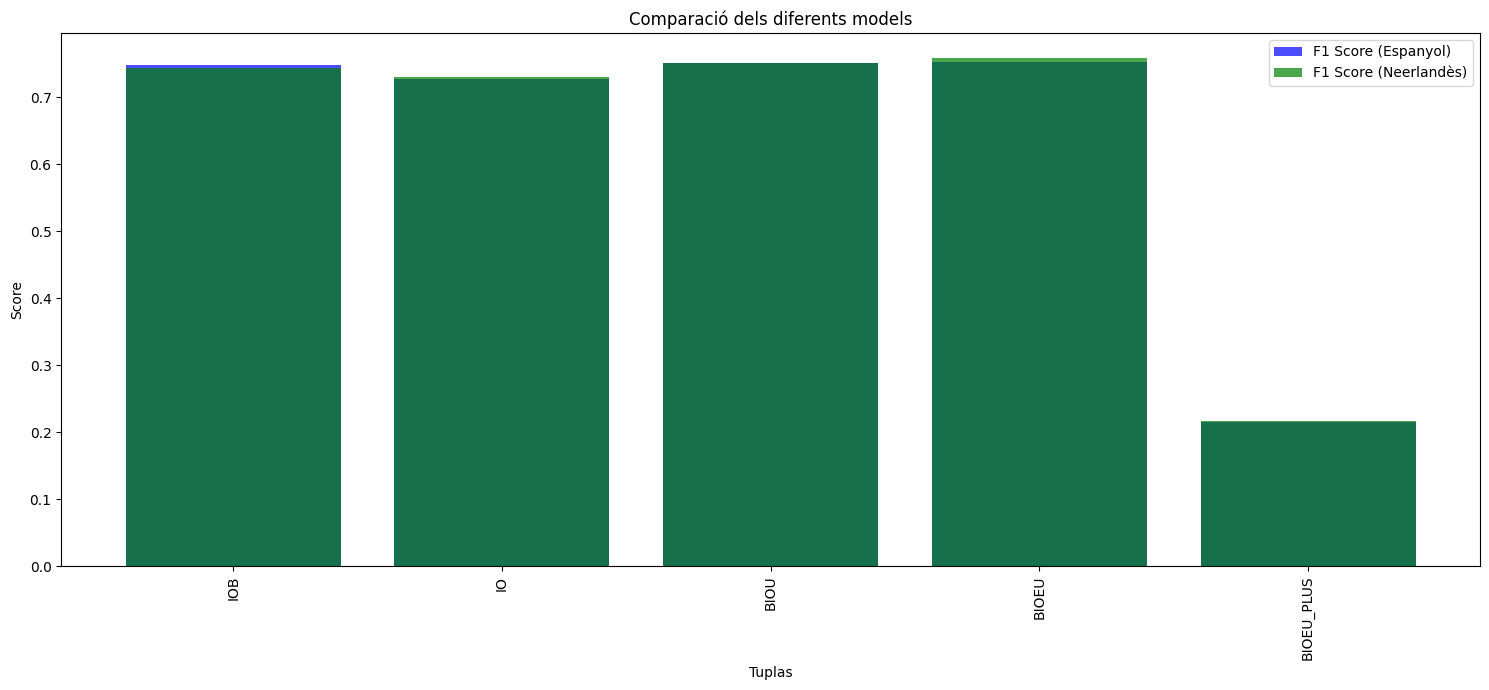

In [68]:
def plot_two_languages():
    # Datos en español
    data_esp = results_esp
    # Datos en neerlandés
    data_ned = results_ned
    # Crea un nuevo gráfico
    plt.figure(figsize=(15,7))

    # Añade los datos en español al gráfico
    plt.bar(data_esp['encoding'], data_esp['f1 score'], color='b', alpha=0.7, label='F1 Score (Espanyol)')

    # Añade los datos en neerlandés al gráfico
    plt.bar(data_ned['encoding'], data_ned['f1 score'], color='g', alpha=0.7, label='F1 Score (Neerlandès)')

    # Añade títulos y etiquetas
    plt.xlabel('Tuplas')
    plt.ylabel('Score')
    plt.title('Comparació dels diferents models')
    plt.xticks(rotation=90) # Esto hace que las etiquetas del eje x se giren 90 grados para evitar la superposición.
    plt.legend()

    # Muestra el gráfico
    plt.tight_layout()
    plt.show()

# Llama a la función para generar el gráfico
plot_two_languages()


#### Testejar els models finals

In [89]:
def testejar_model(lan):
    cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc_bin,otros_bin = eval(f'millor_model_{lan.lower()}')
    if loc_bin == 1:
        loc = eval(f'loc_{lan}')
    else:
        loc = 0
    if otros_bin == 1:
        otros = eval(f'otros_{lan}')
    else:
        otros = 0
    codific = eval(f'millor_cod_{lan.lower()}')
    mod = model(lan,codific,FeatureDetector(cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc,otros))
    mod.train_model()
    recall, precission, f1_score = mod.test_model()
    return recall, precission, f1_score

In [96]:
#ESPANYOL
recall_esp, precission_esp, f1_score_esp = testejar_model('ESP')
print('Recall:',recall_esp,'\nPrecision:', precission_esp,'\nF1 score:',f1_score_esp)

  El model BIOEU_ESP_111110111111.mdl ja estava entrenat
Recall: 0.7819422033152413 
Precision: 0.8080187964226163 
F1 score: 0.7947666616967347


In [97]:
#NEERLANDÈS
recall_ned, precission_ned, f1_score_ned = testejar_model('NED')
print('Recall:',recall_ned,'\nPrecision:', precission_ned,'\nF1 score:',f1_score_ned)

  El model BIOEU_NED_110111111111.mdl ja estava entrenat
Recall: 0.7499660740941784 
Precision: 0.808558888076079 
F1 score: 0.7781610813855252


## PROVA EL TEU PROPI MODEL

In [21]:
#Llibreries necessàries
import ipywidgets as widgets
from ipywidgets import interact, HBox, VBox
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import warnings
from sklearn.exceptions import ConvergenceWarning
from colorama import Fore, Style


In [74]:
from IPython.display import display, HTML

def visualizar_entidades(palabras, entidades):
    colores = {
        'PER': ('red', 'Persona'),
        'LOC': ('blue', 'Lugar'),
        'ORG': ('green', 'Organización'),
        'OTRO': ('purple', 'Otro')
    }

    tipos_entidades = set()

    for i in range(len(palabras)):
        entidades_oracion = entidades[i]

        for _, _, tipo in entidades_oracion:
            tipos_entidades.add(tipo)

    tipos_entidades = sorted(tipos_entidades, key=lambda x: x.lower())

    lineas_previas = []
    for tipo_entidad in tipos_entidades:
        color, nombre = colores.get(tipo_entidad, ('purple', tipo_entidad))
        linea_previa = f'<span style="color: {color}; font-weight: bold;">{tipo_entidad}</span>: {nombre}'
        lineas_previas.append(linea_previa)

    lineas_previas_html = ', '.join(lineas_previas)
    lineas_previas_html = f'<p>{lineas_previas_html}</p>'
    html_lineas_previas = HTML(lineas_previas_html)

    display(html_lineas_previas)

    for i in range(len(palabras)):
        oracion = palabras[i]
        entidades_oracion = entidades[i]

        html_text = ''

        for j in range(len(oracion)):
            palabra = oracion[j]
            tipo_entidad = None

            # Verifica si j está dentro del rango de alguna entidad
            for ini, fin, tipo in entidades_oracion:
                fin += 1
                if ini <= j < fin:
                    tipo_entidad = tipo
                    break

            if tipo_entidad is not None:
                # Cambia el color en función del tipo de entidad
                color = colores.get(tipo_entidad, ('purple', 'OTRO'))[0]
                html_text += f'<span style="color: {color};">{palabra}</span> '
            else:
                html_text += f'{palabra} '

        # Crea y muestra el widget HTML
        html_widget = HTML(html_text)
        display(html_widget)


In [72]:
def identify(idioma, codific, features_addicionals, textarea):
    cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc_bin,otros_bin = features_addicionals
    cap = 1 if cap else 0
    num = 1 if num else 0
    punt = 1 if punt else 0
    suf = 1 if suf else 0
    lon = 1 if lon else 0
    pref = 1 if pref else 0
    lemma = 1 if lemma else 0
    postag = 1 if postag else 0
    ant = 1 if ant else 0
    post = 1 if post else 0
    loc_bin = 1 if loc_bin else 0
    otros_bin = 1 if otros_bin else 0

    if idioma == 'Español':
        lan = 'ESP'
    else:
        lan = 'NED'

    if loc_bin == 1:
        loc = eval(f'loc_{lan}')
    else:
        loc = 0
    if otros_bin == 1:
        otros = eval(f'otros_{lan}')
    else:
        otros = 0
        
    mod = model(lan,codific,FeatureDetector(cap,num,punt,suf,lon,pref,lemma,postag,ant,post,loc,otros))
    mod.train_model()
    dades, pred = mod.try_text(textarea)
    paraules = [[par for par, _ in sent] for sent in dades]
    return paraules, pred


In [ ]:
# Definición de los widgets ToggleButtons con estilos mejorados
idioma = widgets.ToggleButtons(
    options=['Español', 'Neerlandés'],
    description='IDIOMA:',
    disabled=False,
    button_style='success',  # 'success' añade un estilo verde al botón
    tooltips=['Idioma Español', 'Idioma Neerlandés'],
)

codific = widgets.ToggleButtons(
    options=['IOB', 'IO', 'BIOU', 'BIOEU', 'BIOU_PLUS'],
    description='ENCODING:',
    disabled=False,
    button_style='info',  # 'info' añade un estilo azul al botón
    tooltips=['Encoding IOB', 'Encoding IO', 'Encoding BIOU', 'Encoding BIOEU', 'Encoding BIOU_PLUS'],
)

checkboxes = [
    widgets.Checkbox(value=True, description='Capitalization', disabled=False),
    widgets.Checkbox(value=True, description='Números', disabled=False),
    widgets.Checkbox(value=True, description='Signes de puntuació', disabled=False),
    widgets.Checkbox(value=True, description='Sufixos', disabled=False),
    widgets.Checkbox(value=True, description='Longitud de la paraula', disabled=False),
    widgets.Checkbox(value=True, description='Prefix', disabled=False),
    widgets.Checkbox(value=True, description='Lema', disabled=False),
    widgets.Checkbox(value=True, description='Pos Tag', disabled=False),
    widgets.Checkbox(value=True, description='Paraula anterior', disabled=False),
    widgets.Checkbox(value=True, description='Paraula posterior', disabled=False),
    widgets.Checkbox(value=True, description='Gazatteers Localització', disabled=False),
    widgets.Checkbox(value=True, description='Gazatteers Genèric', disabled=False),
]

label = widgets.Label(value="EXTRACCIÓ DE FEATURES:")

features_addicionals = widgets.VBox([label, widgets.GridBox(checkboxes, layout=widgets.Layout(grid_template_columns="repeat(2, 1fr)"))])

textarea = widgets.Textarea(
    value='The movie Harry Potter lacks emotional depth and bland action, leaving the viewer disconnected and bored.',
    placeholder='Type something',
    description="TEXT:",
    layout=widgets.Layout(width='80%', height='100x'),
    disabled=False,
)


def on_button_click(b):
    with output:
        # Obtiene los valores de todos los checkboxes
        checkbox_values = tuple(checkbox.value for checkbox in checkboxes)
        AA, BB = identificar(idioma.value, codific.value, checkbox_values, textarea.value)
        visualizar_entidades(AA, BB)


def identificar(idioma, codific, features_addicionals, textarea):
    clear_output(wait=True)
    print('  Obtenint resultats...\n')
    paraules, pred = identify(idioma, codific, features_addicionals, textarea)
    return paraules, pred


button = widgets.Button(description="Identificar", button_style='warning')  # 'warning' añade un estilo naranja al botón

output = widgets.Output()

container = widgets.VBox([idioma, codific, features_addicionals, textarea])

button.on_click(on_button_click)
widgets_box = widgets.VBox([container, button, output])
display(widgets_box)


In [ ]:
espanyol: pref
neerlandes: num

ambdos BIOEU

https://www.telegraaf.nl/nieuws/1246688829/ontvoerde-kayla-15-in-vs-na-zes-jaar-teruggevonden-dankzij-netflixserie


Slechts negen jaar oud was Kayla Unbehaun toen haar moeder Heather haar 4 juli 2017 weghaalde bij haar vader. Haar moeder had alleen bezoekrechten, de volledige voogdij lag bij Kayla’s vader. Toen hij de volgende dag zijn dochter wilde ophalen bij zijn ex-vrouw, waren ze allebei verdwenen. Nadat er jarenlang geen enkel spoor van Kayla en Heather te bekennen was, kwam haar ontvoering aan het licht in een aflevering van de Netflixserie 'Unsolved Mysteries'. Ook werd vorige maand een foto vrijgegeven door het Amerikaanse National Center for Missing and Exploited Children (NCMEC) met hoe onderzoekers dachten dat Kayla er nu uit zou zien. En dus niet zonder succes. Een winkelmedewerker in de plaats Asheville herkende Kayla omdat hij de serie had gezien. De politie kwam ter plaatse en kon Heather arresteren. Kayla werd herenigd met haar vader. Heather wordt verdacht van kinderontvoering en zit nog altijd vast.